# 1 DQN

# 车上杆的平衡环境

In [1]:
import random
import gym
import numpy as np
import collections
from tqdm import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils


class ReplayBuffer:
    ''' 经验回放池 
    首先定义经验回放池的类，主要包括加入数据、采样数据两大函数。
    '''
    def __init__(self, capacity):
        # 队列,先进先出,创建一个内部最大可容纳capacity个数据的类似列表的双端队列。
        self.buffer = collections.deque(maxlen=capacity)  

    def add(self, state, action, reward, next_state, done):  # 将数据加入buffer
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):  
        # 从buffer中采样数据,数量为batch_size
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done

    def size(self):  
        # 目前buffer中数据的数量
        return len(self.buffer)
    
# 然后定义一个只有一层隐藏层的 Q 网络。
class Qnet(torch.nn.Module):
    ''' 只有一层隐藏层的Q网络
    该网络的输入为当前状态s
    输出为在当前状态s下采取各个动作$a_i$的动作价值函数$Q(s,a_i)$
    '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))  # 隐藏层使用ReLU激活函数
        return self.fc2(x)
    
# 有了这些基本组件之后，接来下开始实现 DQN 算法。
class DQN:
    ''' DQN算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma,
                 epsilon, target_update, device):
        self.action_dim = action_dim
        self.q_net = Qnet(state_dim, hidden_dim,
                          self.action_dim).to(device)  # Q网络
        # 目标网络
        self.target_q_net = Qnet(state_dim, hidden_dim,
                                 self.action_dim).to(device)
        # 使用Adam优化器
        self.optimizer = torch.optim.Adam(self.q_net.parameters(),
                                          lr=learning_rate)
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略
        self.target_update = target_update  # 目标网络更新频率
        self.count = 0  # 计数器,记录更新次数
        self.device = device

    def take_action(self, state):  
        # epsilon-贪婪策略采取动作
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:  
            # 选取当前状态下使动作价值Q最大的action
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return action

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        # self.q_net输出Size([batch_size, 2])，传入当前状态s，输出该状态下每个a下的最大价值函数$Q(s,a_i)$
        # q_values: Size([batch_size, 1])，该值是Q(s,a),即当前状态选择动作a的动作价值函数
        # gather:按列填充qvalue，将action每一列的值作为索引，从qnet输出的每一行拿出该位置的值
        q_values = self.q_net(states).gather(1, actions)  
        # 从target目标网络中获取下个状态在所有动作中的最大动作价值$max_{a^,}Q(s^,a^,)$，保证了训练的稳定
        # A.max(1)：返回两个数：A每一行最大值组成的一维数组和对应数的索引
        max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1) 
        # TD误差目标
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)  
        # 均方误差损失函数
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))  
        # PyTorch中默认梯度会累积,这里需要显式将梯度置为0，梯度设为0，清空过往梯度
        self.optimizer.zero_grad()   
        dqn_loss.backward()  # 反向传播，计算当前梯度；
        self.optimizer.step() # 更新参数的值，根据梯度更新网络参数
        # 当q_net网络每训练一定次数，对target_qnet目标网络的参数进行一次更新
        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(
                self.q_net.state_dict())  # 更新目标网络
        self.count += 1
        
        
# gym版本要求：pip install gym==0.18.3

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
env_name = 'CartPole-v0'
env = gym.make(env_name)
random.seed(0)
np.random.seed(0)
env.seed(0)
# env.reset(seed=0)  高版本的gym用这个方法创建seed

torch.manual_seed(0)
buffer_size = 10000
replay_buffer = ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]  # 4
hidden_dim = 128
action_dim = env.action_space.n  # 2
gamma = 0.98
lr = 2e-3
epsilon = 0.01
target_update = 10

agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device)

D:\editor\pythonProject\pythonProject1\venv\lib\site-packages\gym\envs\registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


# 1.2 trainging

Iteration 0:   0%|                                 | 0/50 [00:00<?, ?it/s]


state, action, reward, next_state, done [-0.01310465 -0.14877215 -0.05026826  0.2543471 ] 0 1.0 [-0.01310465 -0.14877215 -0.05026826  0.2543471 ] False
state, action, reward, next_state, done [-0.01608009 -0.34314166 -0.04518132  0.53076043] 0 1.0 [-0.01608009 -0.34314166 -0.04518132  0.53076043] False
state, action, reward, next_state, done [-0.02294293 -0.53759991 -0.03456611  0.80887136] 0 1.0 [-0.02294293 -0.53759991 -0.03456611  0.80887136] False
state, action, reward, next_state, done [-0.03369493 -0.73223158 -0.01838868  1.09048405] 0 1.0 [-0.03369493 -0.73223158 -0.01838868  1.09048405] False
state, action, reward, next_state, done [-0.04833956 -0.92710638  0.003421    1.37734087] 0 1.0 [-0.04833956 -0.92710638  0.003421    1.37734087] False
state, action, reward, next_state, done [-0.06688168 -0.73202733  0.03096781  1.08572977] 1 1.0 [-0.06688168 -0.73202733  0.03096781  1.08572977] False
state, action, reward, next_state, done [-0.08152223 -0.9275438   0.05268241  1.38796694

Iteration 1:   0%|                                 | 0/50 [00:00<?, ?it/s]


state, action, reward, next_state, done [ 0.0465928  -0.21983082  0.04264826  0.34227369] 0 1.0 [ 0.0465928  -0.21983082  0.04264826  0.34227369] False
state, action, reward, next_state, done [ 0.04219618 -0.41553277  0.04949373  0.64809447] 0 1.0 [ 0.04219618 -0.41553277  0.04949373  0.64809447] False
state, action, reward, next_state, done [ 0.03388553 -0.61130804  0.06245562  0.95594298] 0 1.0 [ 0.03388553 -0.61130804  0.06245562  0.95594298] False
state, action, reward, next_state, done [ 0.02165937 -0.80721188  0.08157448  1.26757583] 0 1.0 [ 0.02165937 -0.80721188  0.08157448  1.26757583] False
state, action, reward, next_state, done [ 0.00551513 -1.00327556  0.106926    1.58464969] 0 1.0 [ 0.00551513 -1.00327556  0.106926    1.58464969] False
state, action, reward, next_state, done [-0.01455038 -1.19949434  0.13861899  1.90867329] 0 1.0 [-0.01455038 -1.19949434  0.13861899  1.90867329] False
state, action, reward, next_state, done [-0.03854027 -1.39581356  0.17679246  2.240951  

Iteration 2:   0%|                                 | 0/50 [00:00<?, ?it/s]


state, action, reward, next_state, done [ 0.00529372 -0.1528915  -0.04368514  0.24099938] 0 1.0 [ 0.00529372 -0.1528915  -0.04368514  0.24099938] False
state, action, reward, next_state, done [ 0.00223589 -0.34736307 -0.03886516  0.51958909] 0 1.0 [ 0.00223589 -0.34736307 -0.03886516  0.51958909] False
state, action, reward, next_state, done [-0.00471137 -0.54191694 -0.02847337  0.79977604] 0 1.0 [-0.00471137 -0.54191694 -0.02847337  0.79977604] False
state, action, reward, next_state, done [-0.01554971 -0.73663698 -0.01247785  1.08336767] 0 1.0 [-0.01554971 -0.73663698 -0.01247785  1.08336767] False
state, action, reward, next_state, done [-0.03028245 -0.93159207  0.0091895   1.37210914] 0 1.0 [-0.03028245 -0.93159207  0.0091895   1.37210914] False
state, action, reward, next_state, done [-0.04891429 -1.12682772  0.03663168  1.66765192] 0 1.0 [-0.04891429 -1.12682772  0.03663168  1.66765192] False
state, action, reward, next_state, done [-0.07145085 -1.32235599  0.06998472  1.97151488

Iteration 3:   0%|                                 | 0/50 [00:00<?, ?it/s]


state, action, reward, next_state, done [ 0.0389085  -0.21310224 -0.01856664  0.26851371] 0 1.0 [ 0.0389085  -0.21310224 -0.01856664  0.26851371] False
state, action, reward, next_state, done [ 0.03464646 -0.40795437 -0.01319637  0.55528325] 0 1.0 [ 0.03464646 -0.40795437 -0.01319637  0.55528325] False
state, action, reward, next_state, done [ 0.02648737 -0.60288858 -0.0020907   0.84377948] 0 1.0 [ 0.02648737 -0.60288858 -0.0020907   0.84377948] False
state, action, reward, next_state, done [ 0.0144296  -0.79798193  0.01478489  1.13580421] 0 1.0 [ 0.0144296  -0.79798193  0.01478489  1.13580421] False
state, action, reward, next_state, done [-0.00153004 -0.99329416  0.03750097  1.43308713] 0 1.0 [-0.00153004 -0.99329416  0.03750097  1.43308713] False
state, action, reward, next_state, done [-0.02139592 -1.18885819  0.06616271  1.73724963] 0 1.0 [-0.02139592 -1.18885819  0.06616271  1.73724963] False
state, action, reward, next_state, done [-0.04517309 -1.38466895  0.1009077   2.04976078

Iteration 4:   0%|                                 | 0/50 [00:00<?, ?it/s]


state, action, reward, next_state, done [ 0.01928599 -0.15215952  0.04925264  0.28219978] 0 1.0 [ 0.01928599 -0.15215952  0.04925264  0.28219978] False
state, action, reward, next_state, done [ 0.0162428  -0.34794814  0.05489664  0.59000099] 0 1.0 [ 0.0162428  -0.34794814  0.05489664  0.59000099] False
state, action, reward, next_state, done [ 0.00928384 -0.54379403  0.06669666  0.89945879] 0 1.0 [ 0.00928384 -0.54379403  0.06669666  0.89945879] False
state, action, reward, next_state, done [-0.00159204 -0.73975338  0.08468583  1.21233855] 0 1.0 [-0.00159204 -0.73975338  0.08468583  1.21233855] False
state, action, reward, next_state, done [-0.01638711 -0.9358601   0.1089326   1.53031234] 0 1.0 [-0.01638711 -0.9358601   0.1089326   1.53031234] False
state, action, reward, next_state, done [-0.03510431 -1.13211386  0.13953885  1.85491098] 0 1.0 [-0.03510431 -1.13211386  0.13953885  1.85491098] False
state, action, reward, next_state, done [-0.05774659 -1.32846631  0.17663707  2.18746833

Iteration 5:   0%|                                 | 0/50 [00:00<?, ?it/s]


state, action, reward, next_state, done [ 0.03625478 -0.23204046 -0.03857728  0.29169977] 0 1.0 [ 0.03625478 -0.23204046 -0.03857728  0.29169977] False
state, action, reward, next_state, done [ 0.03161397 -0.42659173 -0.03274328  0.57197065] 0 1.0 [ 0.03161397 -0.42659173 -0.03274328  0.57197065] False
state, action, reward, next_state, done [ 0.02308213 -0.62123961 -0.02130387  0.85416117] 0 1.0 [ 0.02308213 -0.62123961 -0.02130387  0.85416117] False
state, action, reward, next_state, done [ 0.01065734 -0.81606482 -0.00422064  1.14006981] 0 1.0 [ 0.01065734 -0.81606482 -0.00422064  1.14006981] False
state, action, reward, next_state, done [-0.00566396 -1.01113134  0.01858075  1.43142611] 0 1.0 [-0.00566396 -1.01113134  0.01858075  1.43142611] False
state, action, reward, next_state, done [-0.02588658 -1.20647763  0.04720927  1.72985739] 0 1.0 [-0.02588658 -1.20647763  0.04720927  1.72985739] False
state, action, reward, next_state, done [-0.05001614 -1.40210598  0.08180642  2.03684734

Iteration 6:   0%|                                 | 0/50 [00:00<?, ?it/s]


state, action, reward, next_state, done [ 0.00648396 -0.23746151  0.02922442  0.28708252] 0 1.0 [ 0.00648396 -0.23746151  0.02922442  0.28708252] False
state, action, reward, next_state, done [ 0.00173473 -0.43298778  0.03496607  0.58883745] 0 1.0 [ 0.00173473 -0.43298778  0.03496607  0.58883745] False
state, action, reward, next_state, done [-0.00692502 -0.62858147  0.04674282  0.89232658] 0 1.0 [-0.00692502 -0.62858147  0.04674282  0.89232658] False
state, action, reward, next_state, done [-0.01949665 -0.82430524  0.06458935  1.19932895] 0 1.0 [-0.01949665 -0.82430524  0.06458935  1.19932895] False
state, action, reward, next_state, done [-0.03598276 -1.02020063  0.08857593  1.5115354 ] 0 1.0 [-0.03598276 -1.02020063  0.08857593  1.5115354 ] False
state, action, reward, next_state, done [-0.05638677 -1.21627681  0.11880664  1.83050394] 0 1.0 [-0.05638677 -1.21627681  0.11880664  1.83050394] False
state, action, reward, next_state, done [-0.0807123  -1.41249746  0.15541672  2.15760715

Iteration 7:   0%|                                 | 0/50 [00:00<?, ?it/s]


state, action, reward, next_state, done [ 0.04257711 -0.16977579 -0.04044967  0.30465062] 0 1.0 [ 0.04257711 -0.16977579 -0.04044967  0.30465062] False
state, action, reward, next_state, done [ 0.03918159 -0.36429865 -0.03435666  0.58430728] 0 1.0 [ 0.03918159 -0.36429865 -0.03435666  0.58430728] False
state, action, reward, next_state, done [ 0.03189562 -0.55892291 -0.02267051  0.86597251] 0 1.0 [ 0.03189562 -0.55892291 -0.02267051  0.86597251] False
state, action, reward, next_state, done [ 0.02071716 -0.7537291  -0.00535106  1.15144215] 0 1.0 [ 0.02071716 -0.7537291  -0.00535106  1.15144215] False
state, action, reward, next_state, done [ 0.00564258 -0.94878082  0.01767778  1.44244234] 0 1.0 [ 0.00564258 -0.94878082  0.01767778  1.44244234] False
state, action, reward, next_state, done [-0.01333304 -1.1441159   0.04652663  1.74059617] 0 1.0 [-0.01333304 -1.1441159   0.04652663  1.74059617] False
state, action, reward, next_state, done [-0.03621536 -1.33973571  0.08133855  2.04738225

Iteration 8:   0%|                                 | 0/50 [00:00<?, ?it/s]


state, action, reward, next_state, done [-0.047718   -0.20858946 -0.00634079  0.28912245] 0 1.0 [-0.047718   -0.20858946 -0.00634079  0.28912245] False
state, action, reward, next_state, done [-5.18897869e-02 -4.03620422e-01 -5.58338790e-04  5.79798831e-01] 0 1.0 [-5.18897869e-02 -4.03620422e-01 -5.58338790e-04  5.79798831e-01] False
state, action, reward, next_state, done [-0.0599622  -0.59873454  0.01103764  0.87230582] 0 1.0 [-0.0599622  -0.59873454  0.01103764  0.87230582] False
state, action, reward, next_state, done [-0.07193689 -0.79400484  0.02848375  1.16843842] 0 1.0 [-0.07193689 -0.79400484  0.02848375  1.16843842] False
state, action, reward, next_state, done [-0.08781698 -0.98948554  0.05185252  1.46991362] 0 1.0 [-0.08781698 -0.98948554  0.05185252  1.46991362] False
state, action, reward, next_state, done [-0.10760669 -1.18520208  0.08125079  1.77833166] 0 1.0 [-0.10760669 -1.18520208  0.08125079  1.77833166] False
state, action, reward, next_state, done [-0.13131074 -1.

Iteration 9:   0%|                                 | 0/50 [00:00<?, ?it/s]

state, action, reward, next_state, done [-0.01801186 -0.14576144  0.02811495  0.31848008] 0 1.0 [-0.01801186 -0.14576144  0.02811495  0.31848008] False
state, action, reward, next_state, done [-0.02092709 -0.3412723   0.03448456  0.61989518] 0 1.0 [-0.02092709 -0.3412723   0.03448456  0.61989518] False
state, action, reward, next_state, done [-0.02775253 -0.53685848  0.04688246  0.92323648] 0 1.0 [-0.02775253 -0.53685848  0.04688246  0.92323648] False
state, action, reward, next_state, done [-0.0384897  -0.73258138  0.06534719  1.23027665] 0 1.0 [-0.0384897  -0.73258138  0.06534719  1.23027665] False
state, action, reward, next_state, done [-0.05314133 -0.92848029  0.08995272  1.54269623] 0 1.0 [-0.05314133 -0.92848029  0.08995272  1.54269623] False
state, action, reward, next_state, done [-0.07171094 -1.124561    0.12080665  1.8620386 ] 0 1.0 [-0.07171094 -1.124561    0.12080665  1.8620386 ] False
state, action, reward, next_state, done [-0.09420216 -1.32078251  0.15804742  2.18965653

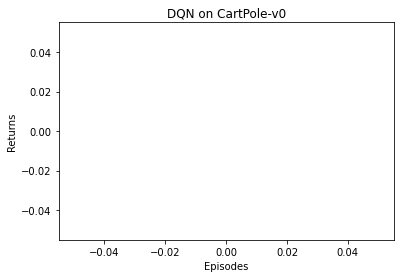

ValueError: operands could not be broadcast together with shapes (0,) (4,) 

In [3]:
num_episodes = 500
minimal_size = 500
batch_size = 64
return_list = []

for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            state = env.reset()
            done = False
            while not done:
                action = agent.take_action(state)
                next_state, reward, done, _ = env.step(action)
                # 将从环境中采样得到的四元组数据(s、a、r、s`)存到经验回放池中
                replay_buffer.add(state, action, reward, next_state, done)  
                print('state, action, reward, next_state, done',state, action, reward, next_state, done)
                state = next_state
                episode_return += reward
                # 当buffer数据的数量超过一定值后,才进行Q网络训练
                if replay_buffer.size() > minimal_size:  
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    transition_dict = {
                        'states': b_s,
                        'actions': b_a,
                        'next_states': b_ns,
                        'rewards': b_r,
                        'dones': b_d
                    }
                    agent.update(transition_dict)
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)
            

            
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

In [ ]:
Note:以下所有操作均在一个采样序列中进行，采样序列循环
1 先在当前状态s根据𝝐-贪婪策略采样一个动作a，然后该动作a与环境交互获得(s`,r,done);
2 将(s,a,r,s`,done)存入经验回放池，并更新当前的状态s和累加r；
3 当经验回放池中的数据buffer达到一定数量，开始在回放池中随机采样n条数据(s,a,r,s`,done);
4 将s输入Q网络获得该状态所有动作的动作价值函数Q,并选取当前状态当前action的Q;
5 将s`输入目标网络获得到s`状态所有动作的动作价值函数Q`,并选取最大的Q`;
6 利用(r,gamma,Q`,done)计算TD误差，并将Q与TD误差计算MSE损失loss，最后将Q的MSEloss送入优化器最小化Q的损失，更新Q网络
7 当Q网络的更新次数达到一定次数时，将当前Q网络的参数传给目标网络。继续周而复始采样序列循环。

In [5]:
class ConvolutionalQnet(torch.nn.Module):
    ''' 加入卷积层的Q网络 '''
    def __init__(self, action_dim, in_channels=4):
        super(ConvolutionalQnet, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = torch.nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc4 = torch.nn.Linear(7 * 7 * 64, 512)
        self.head = torch.nn.Linear(512, action_dim)

    def forward(self, x):
        x = x / 255
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc4(x))
        return self.head(x)

# 2 Double DQN

# 旋转摇摆环境

In [1]:
import random
import gym
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils
from tqdm import tqdm


class Qnet(torch.nn.Module):
    ''' 只有一层隐藏层的Q网络 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)
    
    
class DQN:
    ''' DQN算法,包括Double DQN '''
    def __init__(self,state_dim,hidden_dim,action_dim, learning_rate,gamma,epsilon,target_update,device,dqn_type='VanillaDQN'):
        self.action_dim = action_dim
        self.q_net = Qnet(state_dim, hidden_dim, self.action_dim).to(device)
        self.target_q_net = Qnet(state_dim, hidden_dim,self.action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.q_net.parameters(),lr=learning_rate)
        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update
        self.count = 0
        self.dqn_type = dqn_type
        self.device = device

    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return action
    
    def max_q_value(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        return self.q_net(state).max().item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)  # Q值
        # 下个状态的最大Q值
        if self.dqn_type == 'DoubleDQN': # DQN与Double DQN的区别
            max_action = self.q_net(next_states).max(1)[1].view(-1, 1)  # 使用Q网络选取价值最大的动作a`
            max_next_q_values = self.target_q_net(next_states).gather(1, max_action) # 使用目标网络计算a`的动作价值函数Q`
        else: # DQN的情况。直接在目标网络上选取最优动作的动作价值函数Q`。
            max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1) 
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)  # TD误差目标
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))  # 均方误差损失函数
        self.optimizer.zero_grad()  # PyTorch中默认梯度会累积,这里需要显式将梯度置为0
        dqn_loss.backward()  # 反向传播更新参数
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())  # 更新目标网络
        self.count += 1
        
        
# 设置相应的超参数，并实现将倒立摆环境中的连续动作转化为离散动作的函数。
lr = 1e-2
num_episodes = 200
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 50
buffer_size = 5000
minimal_size = 1000
batch_size = 64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'Pendulum-v0'
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = 11  # 将连续动作分成11个离散动作


def dis_to_con(discrete_action, env, action_dim):  # 离散动作[0,1,2,...,10]转回连续的函数(小数[-2,2])
    action_lowbound = env.action_space.low[0]  # 连续动作的最小值
    action_upbound = env.action_space.high[0]  # 连续动作的最大值
    return action_lowbound + (discrete_action /(action_dim - 1)) * (action_upbound -action_lowbound)

 # 2.2 trainging

In [39]:
def train_DQN(agent, env, num_episodes, replay_buffer, minimal_size,
              batch_size):
    return_list = []
    max_q_value_list = []
    max_q_value = 0
    for i in range(10):
        with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes / 10)):
                episode_return = 0
                state = env.reset()
                done = False
                while not done:
                    action = agent.take_action(state)
                    max_q_value = agent.max_q_value(state) * 0.005 + max_q_value * 0.995  # 平滑处理
                    max_q_value_list.append(max_q_value)  # 保存每个状态的最大Q值
                    action_continuous = dis_to_con(action, env, agent.action_dim)
                    next_state, reward, done, _ = env.step([action_continuous])
                    replay_buffer.add(state, action, reward, next_state, done)
                    state = next_state
                    episode_return += reward
                    if replay_buffer.size() > minimal_size:
                        b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                        transition_dict = {
                            'states': b_s,
                            'actions': b_a,
                            'next_states': b_ns,
                            'rewards': b_r,
                            'dones': b_d
                        }
                        agent.update(transition_dict)
                return_list.append(episode_return)
                if (i_episode + 1) % 10 == 0:
                    pbar.set_postfix({
                        'episode':
                        '%d' % (num_episodes / 10 * i + i_episode + 1),
                        'return':
                        '%.3f' % np.mean(return_list[-10:])
                    })
                pbar.update(1)
    return return_list, max_q_value_list


# 首先训练 DQN 并打印出其学习过程中最大值的情况。
random.seed(0)
np.random.seed(0)
env.seed(0)
torch.manual_seed(0)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device)
return_list, max_q_value_list = train_DQN(agent, env, num_episodes,
                                          replay_buffer, minimal_size,
                                          batch_size)

episodes_list = list(range(len(return_list)))
mv_return = rl_utils.moving_average(return_list, 5)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('DQN on {}'.format(env_name))
plt.show()




# Double DQN 是否能对此问题进行改善。
random.seed(0)
np.random.seed(0)
env.seed(0)
torch.manual_seed(0)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device, 'DoubleDQN')
return_list, max_q_value_list = train_DQN(agent, env, num_episodes,
                                          replay_buffer, minimal_size,
                                          batch_size)

episodes_list = list(range(len(return_list)))
mv_return = rl_utils.moving_average(return_list, 5)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Double DQN on {}'.format(env_name))
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('Double DQN on {}'.format(env_name))
plt.show()

# 3 Dueling DQN 

In [3]:
import random
import gym
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils
from tqdm import tqdm

# Dueling DQN 和DQN差异的仅仅为该神经网络
class VAnet(torch.nn.Module):
    ''' 只有一层隐藏层的A网络和V网络 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(VAnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)  # 共享网络部分
        self.fc_A = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_V = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        A = self.fc_A(F.relu(self.fc1(x)))
        V = self.fc_V(F.relu(self.fc1(x)))
        # Q值由V值和A值计算得到。V.shape=(batchsize,11/action_dim),A.mean(1).view(-1, 1)：shape(batchsize,1),A.shape=(batchsize)
        Q = V + A - A.mean(1).view(-1, 1)  
        return Q

    

class DQN:
    ''' DQN算法,包括Double DQN和Dueling DQN '''
    def __init__(self,
                 state_dim,
                 hidden_dim,
                 action_dim,
                 learning_rate,
                 gamma,
                 epsilon,
                 target_update,
                 device,
                 dqn_type='VanillaDQN'):
        self.action_dim = action_dim
        if dqn_type == 'DuelingDQN':  # Dueling DQN采取不一样的网络框架
            self.q_net = VAnet(state_dim, hidden_dim,
                               self.action_dim).to(device)
            self.target_q_net = VAnet(state_dim, hidden_dim,
                                      self.action_dim).to(device)
        else:
            self.q_net = Qnet(state_dim, hidden_dim,
                              self.action_dim).to(device)
            self.target_q_net = Qnet(state_dim, hidden_dim,
                                     self.action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.q_net.parameters(),
                                          lr=learning_rate)
        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update
        self.count = 0
        self.dqn_type = dqn_type
        self.device = device

    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return action

    def max_q_value(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        return self.q_net(state).max().item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)
        if self.dqn_type == 'DoubleDQN':
            max_action = self.q_net(next_states).max(1)[1].view(-1, 1)
            max_next_q_values = self.target_q_net(next_states).gather(
                1, max_action)
        else:
            max_next_q_values = self.target_q_net(next_states).max(1)[0].view(
                -1, 1)
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))
        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())
        self.count += 1



def train_DQN(agent, env, num_episodes, replay_buffer, minimal_size,
              batch_size):
    return_list = []
    max_q_value_list = []
    max_q_value = 0
    for i in range(10):
        with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes / 10)):
                episode_return = 0
                state = env.reset()
                done = False
                while not done:
                    action = agent.take_action(state)
                    max_q_value = agent.max_q_value(state) * 0.005 + max_q_value * 0.995  # 平滑处理
                    max_q_value_list.append(max_q_value)  # 保存每个状态的最大Q值
                    action_continuous = dis_to_con(action, env, agent.action_dim)
                    next_state, reward, done, _ = env.step([action_continuous])
                    replay_buffer.add(state, action, reward, next_state, done)
                    state = next_state
                    episode_return += reward
                    if replay_buffer.size() > minimal_size:
                        b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                        transition_dict = {
                            'states': b_s,
                            'actions': b_a,
                            'next_states': b_ns,
                            'rewards': b_r,
                            'dones': b_d
                        }
                        agent.update(transition_dict)
                return_list.append(episode_return)
                if (i_episode + 1) % 10 == 0:
                    pbar.set_postfix({
                        'episode':
                        '%d' % (num_episodes / 10 * i + i_episode + 1),
                        'return':
                        '%.3f' % np.mean(return_list[-10:])
                    })
                pbar.update(1)
    return return_list, max_q_value_list




def dis_to_con(discrete_action, env, action_dim):  # 离散动作[0,1,2,...,10]转回连续的函数(小数[-2,2])
    action_lowbound = env.action_space.low[0]  # 连续动作的最小值
    action_upbound = env.action_space.high[0]  # 连续动作的最大值
    return action_lowbound + (discrete_action /(action_dim - 1)) * (action_upbound -action_lowbound)



# 设置相应的超参数，并实现将倒立摆环境中的连续动作转化为离散动作的函数。
lr = 1e-2
num_episodes = 200
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 50
buffer_size = 5000
minimal_size = 1000
batch_size = 64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'Pendulum-v0'
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = 11  # 将连续动作分成11个离散动作

Iteration 0:   0%|                                                                                   | 0/20 [00:00<?, ?it/s]C:\Users\arnol\AppData\Local\Temp\ipykernel_22188\1864530520.py:63: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  state = torch.tensor([state], dtype=torch.float).to(self.device)
Iteration 9: 100%|████████████████████████████████████████████| 20/20 [00:11<00:00,  1.71it/s, episode=200, return=-237.102]


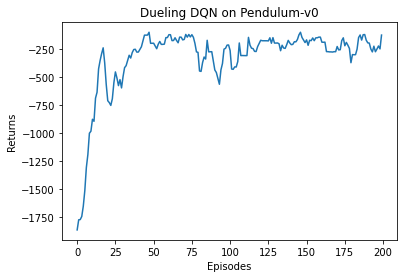

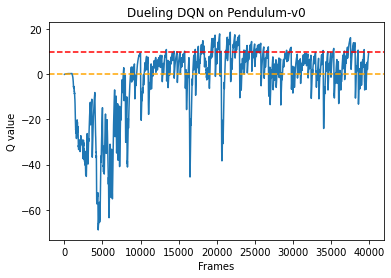

In [2]:
random.seed(0)
np.random.seed(0)
env.seed(0)
torch.manual_seed(0)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device, 'DuelingDQN')
return_list, max_q_value_list = train_DQN(agent, env, num_episodes,
                                          replay_buffer, minimal_size,
                                          batch_size)

episodes_list = list(range(len(return_list)))
mv_return = rl_utils.moving_average(return_list, 5)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Dueling DQN on {}'.format(env_name))
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('Dueling DQN on {}'.format(env_name))
plt.show()

In [38]:
#在tf.keras中实现时使用Binary Crossentropy0，如下所示：
# 导入相应的包

import numpy as np
import tensorflow as tf

# 设置真实值和预測值
y_true = [[0.], [1.]]
y_pred = [[0.4], [0.6]] #sigmoid激活后的结果
# 实例化二类交叉熵损失
bce = tf.keras. losses .BinaryCrossentropy()
# 计算损失结果
api_loss=bce(y_true, y_pred)

b_loss=-(y_true*np.log(y_pred)+(1.-np.array(y_true))*np.log(1.-np.array(y_pred)))
c_loss=-(y_true[0]*np.log2(y_pred[0])+(1.-np.array(y_true[0]))*np.log2(1.-np.array(y_pred[0]))) #np.log默认以e为底

print(api_loss,b_loss,c_loss)

tf.Tensor(0.5108254, shape=(), dtype=float32) [[0.51082562]
 [0.51082562]] [0.73696559]
